# Google trends vs anomalies in name frequency
This notebook uses the pytrends library, which is not supported by Google. Often, while creating this notebook, Google returned a "too many requests" error, even when making very minor & infrequent requests. So the focus of this notebook is to look at a handful of name frequency anomalies and explore if Google trends might predict those anomalies.

In [2]:
import numpy as np
import pandas as pd

from data_loader import load_names_from_web

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pytrends.request import TrendReq

from datetime import datetime

import requests

## get SSA name data and find some anomalies that occurred since 2004

In [3]:
dfraw = load_names_from_web(category="national", hide_pre_1937=True)
dfraw.sample(5)

,state,year,name,M/F,count
1463211,US,1969,Trini,F,25
695301,US,1998,Akemi,F,14
831279,US,1965,Krystine,F,9
19621,US,2000,Taquan,M,53
1023858,US,1977,Brendalee,F,7


In [4]:
dfn1 = dfraw[['name', 'M/F', 'count', 'year']].sort_values(['M/F','name','year'])
dfn1.columns=['name', 'gender', 'count', 'year']
dfn1['diff'] = dfn1.groupby(['gender','name'])['count'].diff()
dfn1['accel'] = dfn1.groupby(['gender','name'])['diff'].diff()
dfn1.head(12)

,name,gender,count,year,diff,accel
529547,Aabha,F,7,2011,NaN,NaN
332735,Aabha,F,5,2012,-2.0,NaN
40723,Aabha,F,9,2014,4.0,6.0
110726,Aabha,F,7,2015,-2.0,-6.0
295685,Aabha,F,7,2016,0.0,2.0
2066820,Aabha,F,6,2019,-1.0,-1.0
1780595,Aabha,F,5,2020,-1.0,0.0
1677182,Aabha,F,5,2021,0.0,1.0
1847356,Aabha,F,5,2022,0.0,0.0
1978085,Aabidah,F,5,2018,NaN,NaN


In [5]:
num_previous_years = 10

dfn2 = dfn1.sort_values(by=['name', 'gender', 'year'])

# note: min_periods=10 means that there won;t be calculations if there are not 10 previous years
# note: shift(1) means the current year is not included ion the average and std dev
dfn2['10yr_ave'] = dfn2.groupby(['name','gender'])['count'].transform(lambda x: x.rolling(window=10, min_periods=10).mean().shift(1))
dfn2['10yr_std'] = dfn2.groupby(['name','gender'])['count'].transform(lambda x: x.rolling(window=10, min_periods=10).std().shift(1))
dfn2['10yr_z_score'] = dfn2['diff'] / dfn2['10yr_std']
dfn2.head()

,name,gender,count,year,diff,accel,10yr_ave,10yr_std,10yr_z_score
448288,Aaban,M,5,2007,NaN,NaN,NaN,NaN,NaN
1658424,Aaban,M,6,2009,1.0,NaN,NaN,NaN,NaN
622298,Aaban,M,9,2010,3.0,2.0,NaN,NaN,NaN
542793,Aaban,M,11,2011,2.0,-1.0,NaN,NaN,NaN
342452,Aaban,M,11,2012,0.0,-2.0,NaN,NaN,NaN


In [6]:
# google trends goes back to 2004
dfn3 = dfn2.loc[dfn2['year']>2003]

In [7]:
# get big anomalies: 
#     overall jumps and drops.
#     high z-scores
anomaly_count = 5
min_10yr_ave = 1000 # a name that jumped from 5 to 10 might have a big z-score, but a diff of 5 is not a big deal
min_anomaly_year = 2012 # let's ignore big changes that occured in early Google times.


z1 = dfn3.loc[(dfn3['10yr_ave']>=min_10yr_ave) & (dfn3['year']>=min_anomaly_year)].sort_values(by=['10yr_z_score']).head(anomaly_count)
z1['type']='z-score drop'

z2 = dfn3.copy()
z2.replace([np.inf, -np.inf], np.nan, inplace=True)
z2 = z2[~pd.isnull(z2['10yr_z_score'])]
z2 = z2.loc[(z2['10yr_ave']>=min_10yr_ave) & (z2['year']>=min_anomaly_year)].sort_values(by=['10yr_z_score']).tail(anomaly_count)
z2['type']='z-score jump'

z3 = dfn3.loc[(dfn3['10yr_ave']>=min_10yr_ave) & (dfn3['year']>=min_anomaly_year)].sort_values(by=['diff']).head(anomaly_count)
z3['type']='overall drop'

# z4 = dfn3[~pd.isnull(dfn3['diff'])].sort_values(by=['diff']).tail(anomaly_count)
z4 = dfn3[~pd.isnull(dfn3['diff'])].loc[(dfn3['10yr_ave']>=min_10yr_ave) & (dfn3['year']>=min_anomaly_year)].sort_values(by=['diff']).tail(anomaly_count)
z4['type']='overall jump'

anomalies = pd.concat([z1, z2, z3, z4], axis=0).reset_index()
anomalies

,index,name,gender,count,year,diff,accel,10yr_ave,10yr_std,10yr_z_score,type
0,450642,Allyson,F,1008,2013,-258.0,-311.0,1280.9,41.197222,-6.262558,z-score drop
1,1962662,Julianna,F,1363,2018,-240.0,-237.0,1701.9,56.740051,-4.229816,z-score drop
2,1980604,Charles,M,6653,2018,-529.0,-589.0,7147.8,138.762627,-3.812266,z-score drop
3,1679784,Emmanuel,M,1977,2021,-483.0,-527.0,2512.5,128.139030,-3.769343,z-score drop
4,1849962,Jude,M,2288,2022,-214.0,-281.0,2527.7,63.603022,-3.364620,z-score drop
5,117090,Kameron,M,1506,2015,211.0,138.0,1261.8,45.606530,4.626530,z-score jump
6,2071281,Kyler,M,1606,2019,472.0,410.0,1245.4,90.838318,5.196045,z-score jump
7,335592,Calvin,M,1965,2012,257.0,210.0,1618.3,46.053230,5.580499,z-score jump
8,469825,Lorenzo,M,1516,2013,428.0,372.0,1037.5,73.121284,5.853289,z-score jump
9,1765543,Gianna,F,7890,2020,4471.0,4497.0,3464.2,333.071831,13.423531,z-score jump


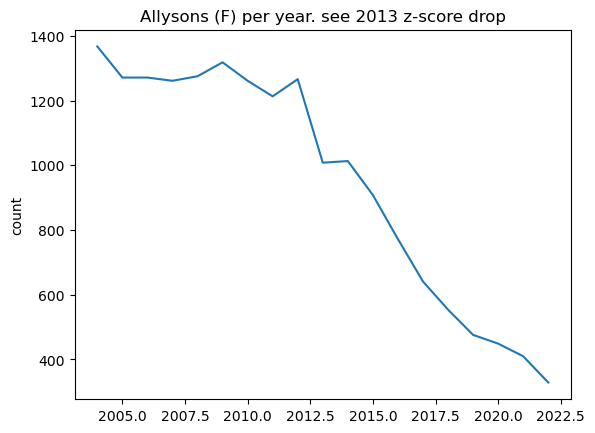

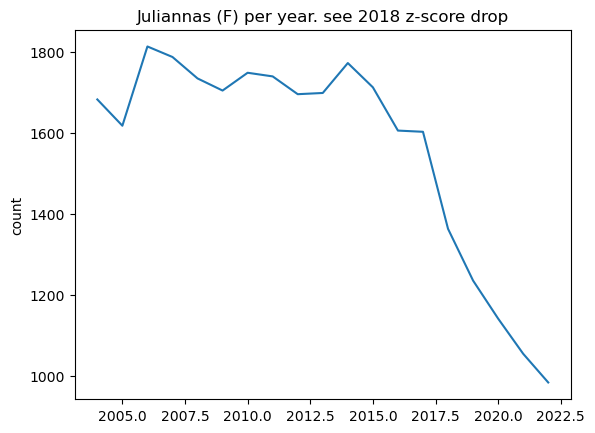

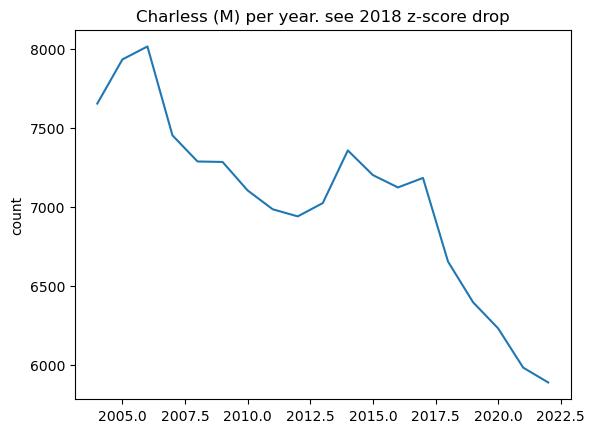

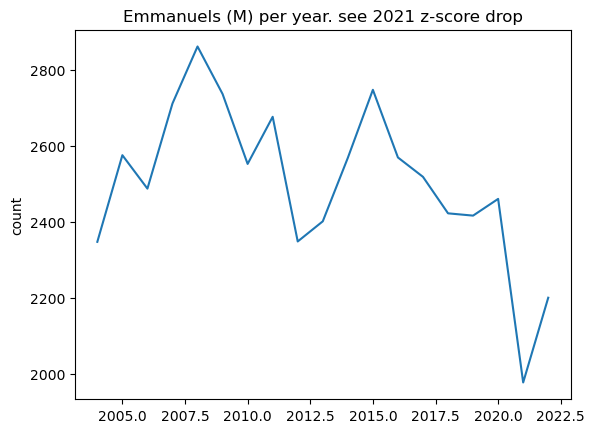

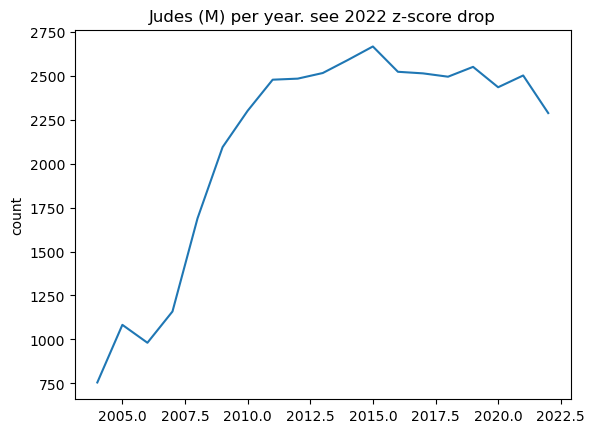

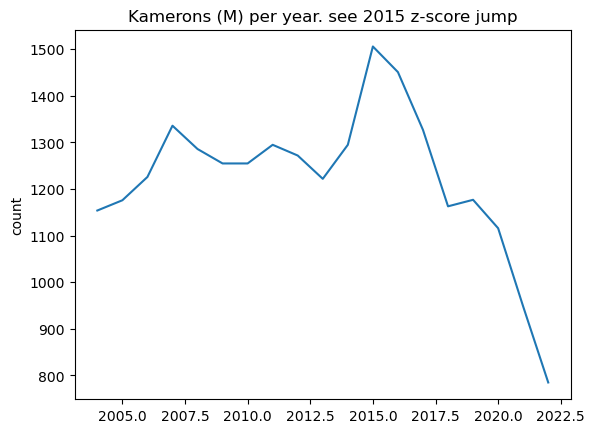

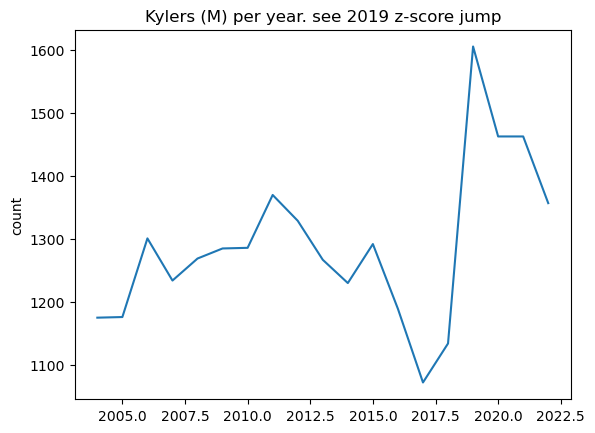

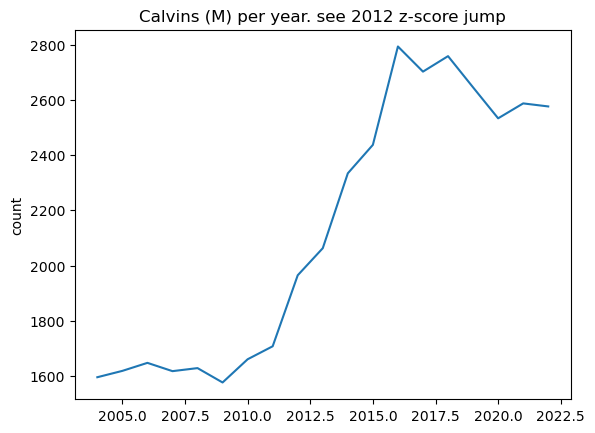

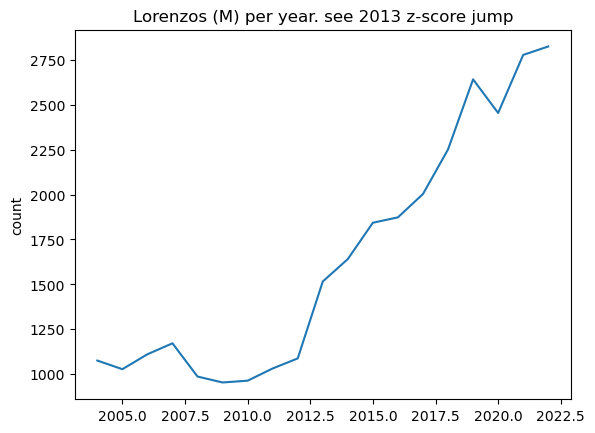

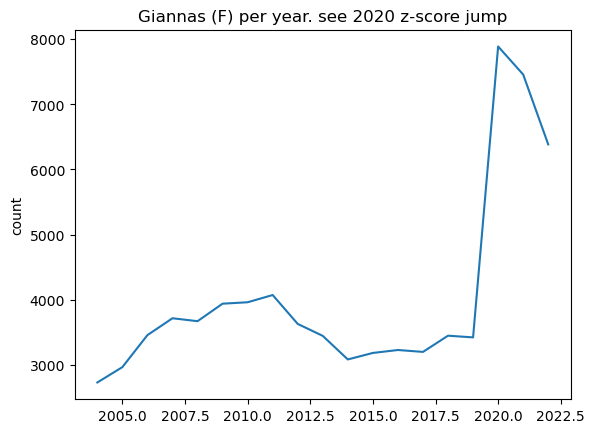

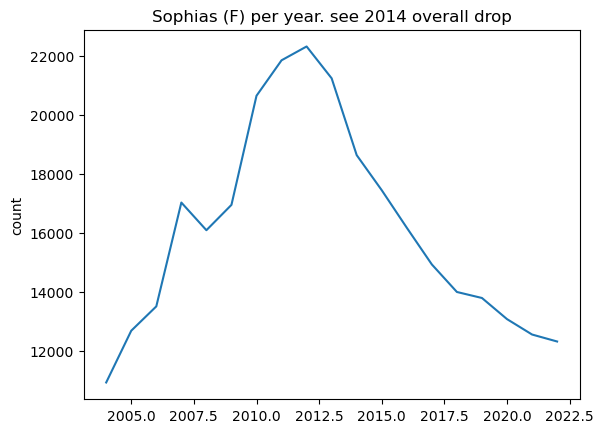

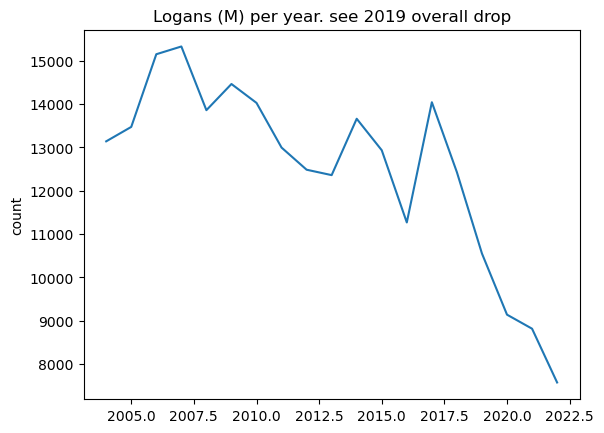

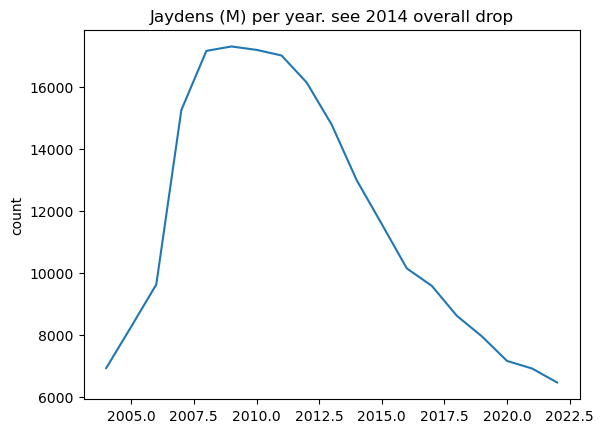

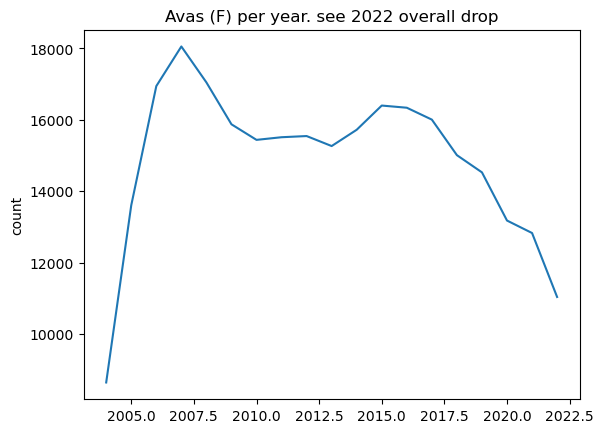

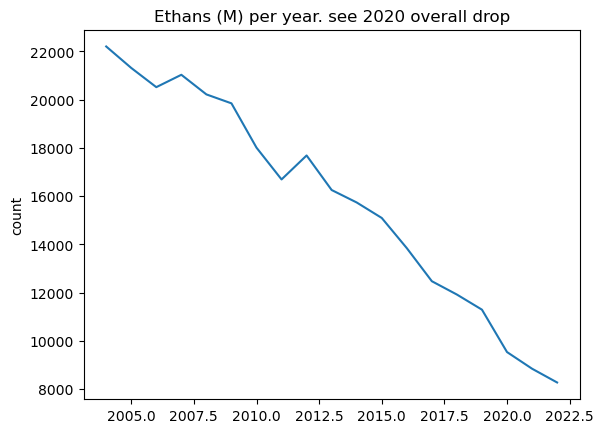

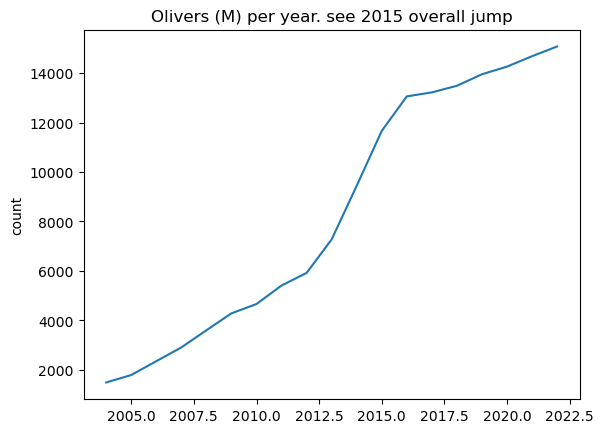

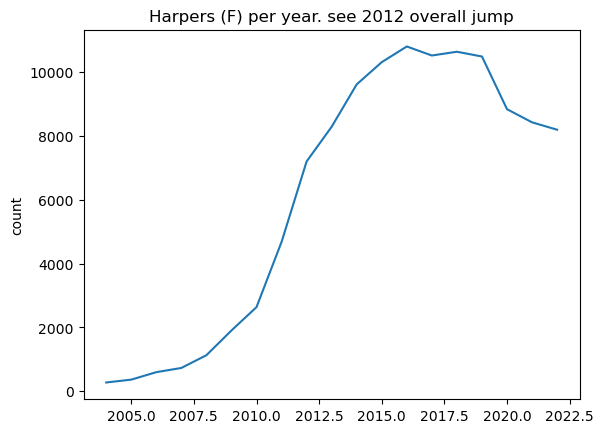

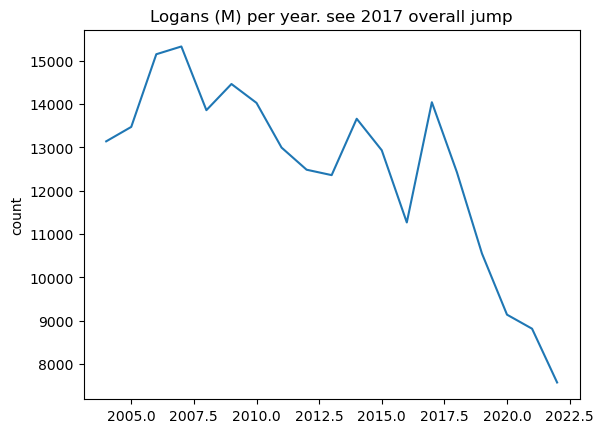

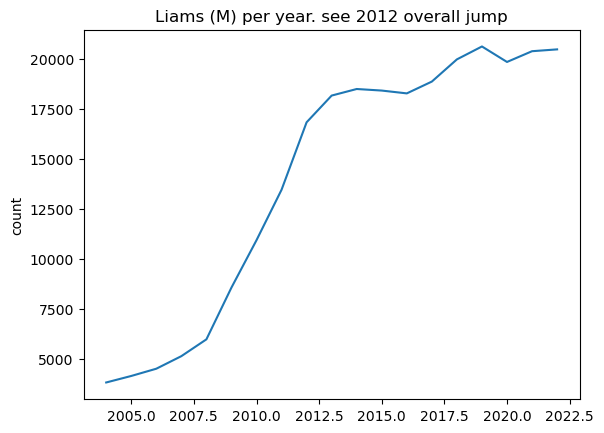

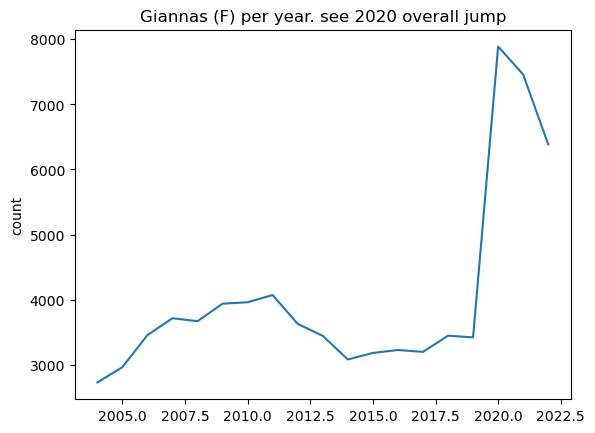

In [8]:
for ind in anomalies.index:
    name = anomalies.name[ind]
    gender = anomalies.gender[ind]
    yr = anomalies.year[ind]
    typ = anomalies.type[ind]
    
    z = dfn3.loc[(dfn3['name']==name) & (dfn3['gender']==gender)].sort_values(['year'])
    plt.plot(z['year'], z['count'])
    plt.ylabel('count')
    plt.title(name + 's (' + gender + ') per year. see ' + str(yr) + ' ' + typ)
    plt.show()    

In [9]:
anomaly_names = list(anomalies['name'])
print(anomaly_names)
# the kw_list maximum length is 5. I will manually choose 5 to start, based on 10yr_ave and z-score
keywords = ['Gianna', 'Logan', 'Charles', 'Ava', 'Harper']
genders = ['F', 'M', 'M', 'F', 'F']
keywords

['Allyson', 'Julianna', 'Charles', 'Emmanuel', 'Jude', 'Kameron', 'Kyler', 'Calvin', 'Lorenzo', 'Gianna', 'Sophia', 'Logan', 'Jayden', 'Ava', 'Ethan', 'Oliver', 'Harper', 'Logan', 'Liam', 'Gianna']


['Gianna', 'Logan', 'Charles', 'Ava', 'Harper']

## load google trends data that was previously saved to csv files
The google trends API is temperamental. This section uses previously saved data.

In [10]:
# load previously saved Google trends data
gtrends = None
for name in keywords:
    file_path = f'google_trends_data/{name}.csv'  
    dftemp = pd.read_csv(file_path)  
    dftemp.drop(['isPartial'], axis=1, inplace=True)

    if gtrends is None:
        gtrends = dftemp
    else:
        gtrends = pd.merge(gtrends, dftemp, on='date', how='outer')    

gtrends['year'] = pd.to_datetime(gtrends['date']).dt.year
gtrends.head()

,date,Gianna,Logan,Charles,Ava,Harper,year
0,2005-01-01,3,13,60,33,26,2005
1,2005-02-01,3,11,77,30,27,2005
2,2005-03-01,3,11,65,29,25,2005
3,2005-04-01,3,12,64,27,26,2005
4,2005-05-01,4,11,59,32,29,2005


In [19]:
trends_yearly = gtrends.groupby(['year'])['Gianna', 'Logan', 'Charles', 'Ava', 'Harper'].sum().reset_index()
trends_yearly.head()

/var/folders/lb/1f9q5kds7h5c90s9vmqdd9qm0000gn/T/ipykernel_971/3813463297.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  trends_yearly = gtrends.groupby(['year'])['Gianna', 'Logan', 'Charles', 'Ava', 'Harper'].sum().reset_index()


,year,Gianna,Logan,Charles,Ava,Harper
0,2005,59,136,738,361,307
1,2006,123,140,623,359,304
2,2007,203,140,591,394,250
3,2008,242,136,587,401,263
4,2009,231,133,576,372,280


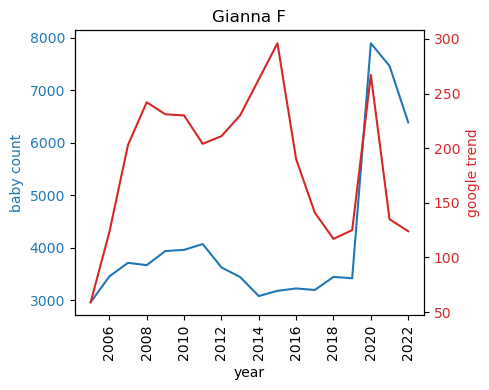

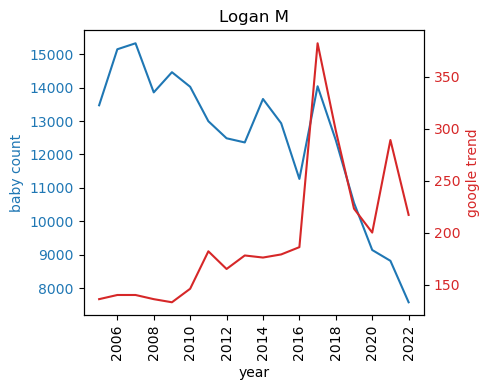

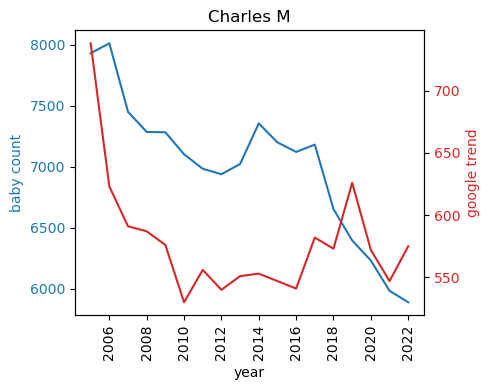

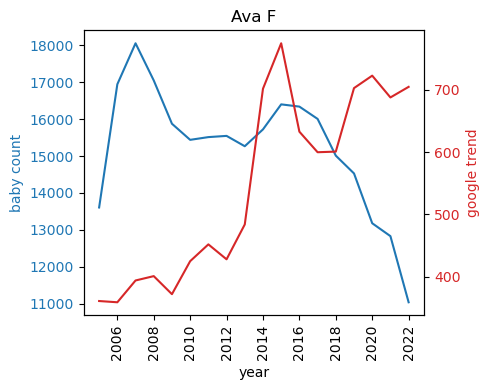

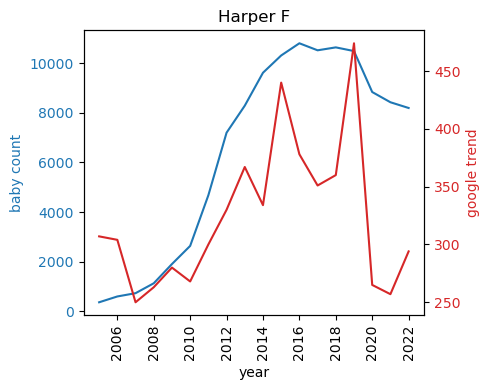

In [39]:

for i in range(0,len(keywords)):
    name = keywords[i]
    gender = genders[i]
    z1 = dfn3.loc[(dfn3['name']==name) & (dfn3['gender']==gender)].sort_values(['year'])
    z2 = trends_yearly[['year', name]]
    z3 = pd.merge(z2, z1, on=['year'])
    
    # z3.plot(x='year', y=['count', name])
    # plt.show()
    fig, ax1 = plt.subplots(figsize = (5,4))
    ax1.set_title(name + ' ' + gender)

    color = 'tab:blue' 
    ax1.set_xlabel('year')
    ax1.set_ylabel('baby count', color=color)  
    ax1.plot(z3['year'], z3['count'], color=color)  
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax1.tick_params(axis='x', rotation=90)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:red'  
    ax2.set_ylabel('google trend', color=color)  
    ax2.plot(z3['year'], z3[name], color=color) 
    ax2.tick_params(axis='y', labelcolor=color) 

    fig.tight_layout()  # Adjust the layout to make room
    plt.show()  # Display the plot    
    
    

## here is how to use the API to get google trends data

## (log into Google using this browser before running)

see https://colab.research.google.com/github/Tanu-N-Prabhu/Python/blob/master/Google_Trends_API.ipynb

install pytrends: 

https://pypi.org/project/pytrends/

In [40]:
# !pip install pytrends

In [41]:
session = requests.Session()
session.get('https://trends.google.com')
cookies_map = session.cookies.get_dict()
nid_cookie = cookies_map['NID']

In [42]:
geo = 'US'
timeframe = '2005-01-01 ' + datetime.now().strftime('%Y-%m-%d')  # just a string represenmting date range
gprop = ''  # Google property: empty means search; could be 'images', 'news', etc.

In [43]:
keywords

['Gianna', 'Logan', 'Charles', 'Ava', 'Harper']

In [44]:
pytrend = TrendReq(requests_args={'headers': {'Cookie': f'NID={nid_cookie}'}})

In [45]:
pytrend.build_payload(kw_list=keywords, geo=geo, timeframe=timeframe, gprop=gprop)

In [46]:
# FYI: Interest by Region (state)
# region_data = pytrend.interest_by_region()
# region_data.head(10)

In [47]:
trends_data = pytrend.interest_over_time()

In [48]:
trends_data.head()

,Gianna,Logan,Charles,Ava,Harper,isPartial
date,,,,,,
2005-01-01,0,11,58,3,7,False
2005-02-01,0,9,78,3,7,False
2005-03-01,0,10,62,3,6,False
2005-04-01,0,11,66,2,7,False
2005-05-01,0,10,58,3,7,False
